In [1]:
import numpy as np
import pandas as pd
import h5py
from fitsio import FITS
from astropy.table import Table, setdiff, vstack, join_skycoord, join
from astropy.coordinates import SkyCoord
import re
from glob import glob


import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.7

file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

filepath =  r"/bsuscratch/shuleicao/Cardinalv3/"

# Load the halos with the DS and Sigma profiles (Corrected File)

In [2]:
### Load the halos with the DS and Sigma profiles
halos_ds =  Table(np.load(file_path+"correctfilev2.npy"))
halos_ds['Sigma'] = halos_ds['Sigma']*1e12*h
halos_ds['DeltaSigma'] = halos_ds['DeltaSigma']*1e12*h
print(len(halos_ds))
print(halos_ds.columns)
halos_ds[:5]

1454571
<TableColumns names=('haloid','Mvir','RA','DEC','Redshift','Rvir','cosi','pid','rs','M200m','R200m','rho','DeltaSigma','Sigma','gtall','weightall','ratio','delta')>


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12905996,1104000000000000.0,116.599,18.9969,0.62517,2.1563340659340655,0.464765,-1,0.377642,1129788000000000.0,2.57077,3232607803046852.0 .. 4951584885294.114,221858585992424.06 .. 4427939692031.291,1737067114879232.8 .. 21554116855032.89,-2.0638824814096005e-05 .. 0.6538981002611183,2.6673175421036414e-07 .. 0.0691232562888688,8.064741778139222 .. 1.0457879038100961,287.8731346185066 .. 5.31543402099229
35142654,963800000000000.0,12.3843,15.0544,0.62133,2.0602021978021976,0.673965,-1,0.409137,991244500000000.0,2.46113,1.1785172540359254e+16 .. 8011401459616.633,224823077386162.56 .. 3112729511600.675,2043845776634292.2 .. 21017359969982.85,0.0 .. 0.1991121235725387,0.0 .. 0.06996756822056328,8.109481193785157 .. 1.0461027816248183,287.34227585727774 .. 5.351987610686462
18168985,684900000000000.0,105.984,37.5753,0.624004,1.83905934065934,0.303402,-1,0.453041,716756000000000.0,2.20896,6752437518712852.0 .. 6507767830265.735,192941861535731.56 .. 754144290934.1284,915199679306494.5 .. 17105744065991.172,3.249494607732e-05 .. -0.4110064147176141,1.935636181807703e-07 .. 0.045596211225709116,8.078284478291293 .. 1.0458832178808715,287.7124427336747 .. 5.326498857167794
25086666,622400000000000.0,79.5485,17.0951,0.621697,1.7808263736263732,0.292845,-1,0.516649,646103600000000.0,2.13357,4540572459218548.0 .. 5335539180106.598,-190920239422305.72 .. 3247461499893.682,1109577404771136.2 .. 21171169375199.383,5.812510298272736e-05 .. 0.07036336975025734,3.678071065972682e-07 .. 0.06765867643987916,10.47001112395602 .. 1.085947576709258,175.47785545631078 .. 5.513249062307372
9757402,608300000000000.0,172.89,42.8772,0.629086,1.7687472527472525,0.039409,-1,0.245139,628887200000000.0,2.11488,9110820848357404.0 .. 5247903714057.773,28000567859192.13 .. 377147965907.6055,1124659319436634.2 .. 15668973637593.557,-4.970286588776491e-05 .. -0.19988896661684516,1.883852082676027e-07 .. 0.06559499054621185,10.622833978017232 .. 1.0848228605758334,175.5979769869793 .. 5.441102290922053


In [3]:
print(halos_ds['Redshift'].min(), halos_ds['Redshift'].max())
print("{:e}".format(halos_ds['Mvir'].min()), "{:e}".format(halos_ds['Mvir'].max()))

0.180002 0.659999
1.001000e+13 1.753000e+15


In [4]:
## Defirne the radial bins
Rmin = 0.1
Rmax = 50
pimax = 100
n_decade = (np.log10(Rmax)-np.log10(Rmin))
nrp_per_decade = 10
n_rp = int(nrp_per_decade*n_decade + 1 + 0.001) ## adding the inner most bin
lnrp = np.linspace(np.log(Rmin), np.log(Rmax), 15) # n_rp
bins = np.exp(lnrp)  #*0.70

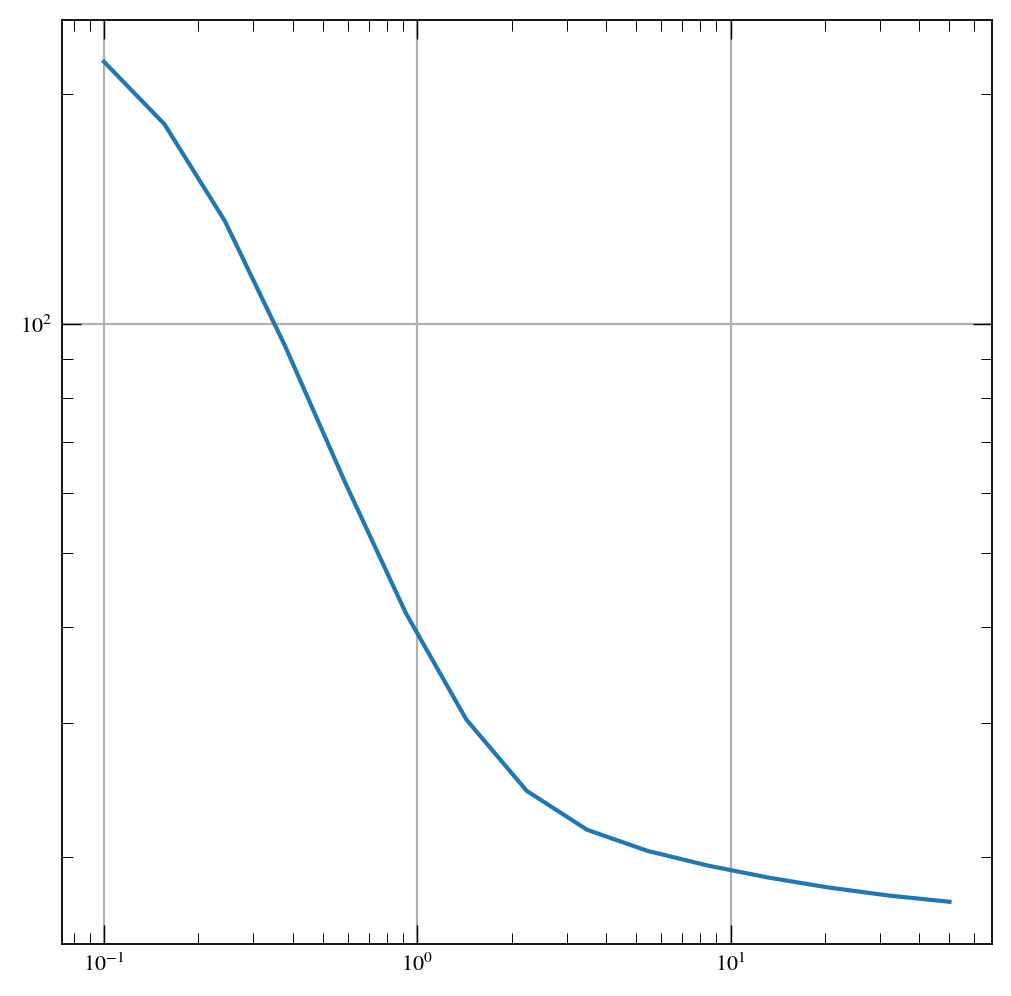

In [4]:
# plt.loglog(bins,(halos_ds['Sigma']*1e12*h).mean(axis=0))  ### Always do this
plt.loglog(bins,(halos_ds['Sigma']).mean(axis=0))

[]

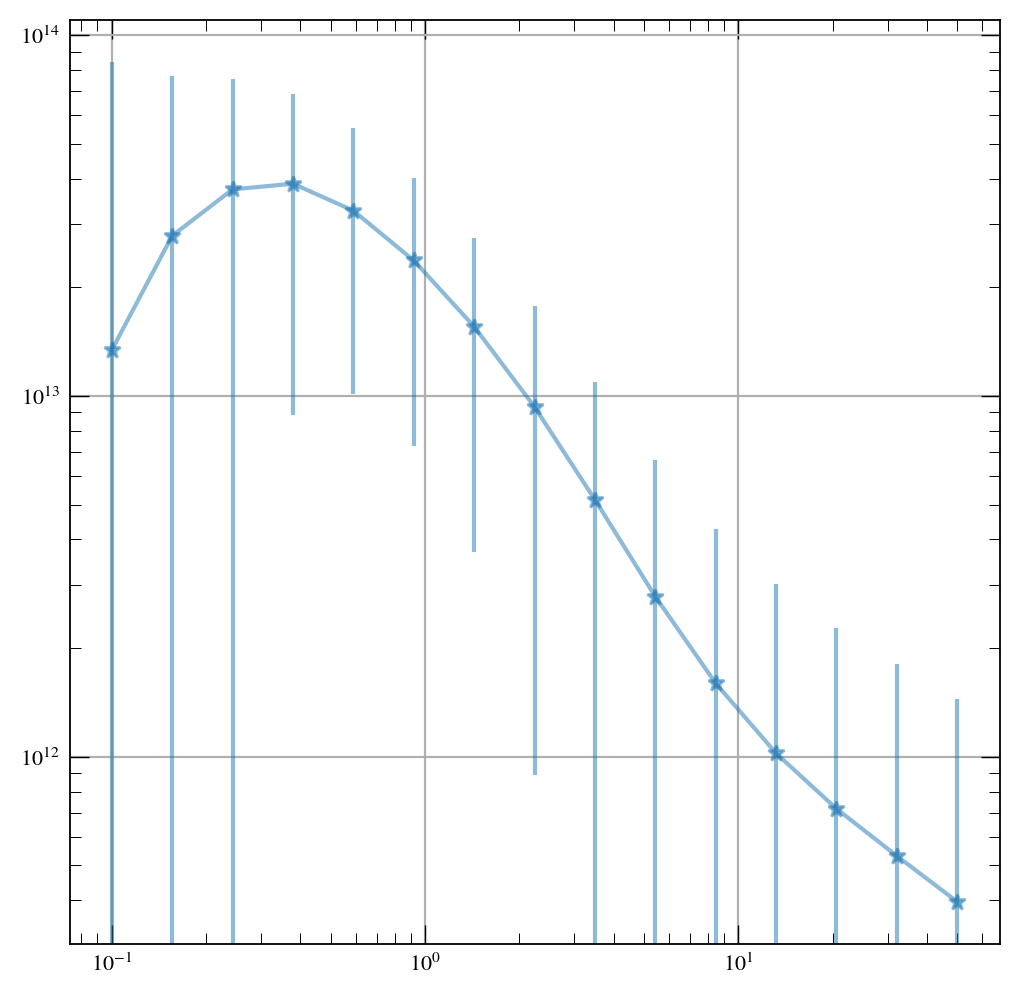

In [28]:
# plt.loglog(bins,halos_ds['DeltaSigma'].mean(axis=0))
plt.errorbar(bins,halos_ds['DeltaSigma'].mean(axis=0),yerr=halos_ds['DeltaSigma'].std(axis=0), marker='*', alpha=0.5)
# plt.errorbar(bins,halos_mathched['DeltaSigma'].mean(axis=0),yerr=np.mean(jackknife_samples, axis=0),alpha=0.5, linestyle=':')
plt.loglog()

In [5]:
sum(halos_ds['M200m']<=0) , sum(halos_ds['Mvir']<=0) , 1454571-648278

(274073, 0, 806293)

In [4]:
### Anything besides -1 is a subhalo
sum(halos_ds['pid']==-1)

1382897

# Reading the redshifts of the gold catalog

In [34]:
#### getting the redshifts of the gold catalog
fname = filepath + 'Cardinal-3_v2.0_Y6a_bpz.h5'
f = h5py.File(fname,'r')
print(f.keys())
catalog = f['catalog']
print(catalog.keys())
bpz = catalog['bpz']
print(bpz.keys())
print(len(bpz['zmc_sof']))
cosm_z = bpz['redshift_cos'][:]
coadd_object_id_z = bpz['coadd_object_id'][:]
print(len(cosm_z))

<KeysViewHDF5 ['catalog']>
<KeysViewHDF5 ['bpz']>
<KeysViewHDF5 ['coadd_object_id', 'redshift_cos', 'z', 'zmc_sof', 'zmean_sof', 'zsigma_sof']>
1399546088
1399546088


# Reading the gold catalog

In [7]:
#### Loading the gold catalog
fname = filepath + 'Cardinal-3_v2.0_Y6a_gold.h5'
f = h5py.File(fname,'r')
print(f.keys())
catalog = f['catalog']
print(catalog.keys())
gold = catalog['gold']
print(len(gold['rhalo']))
print(gold.keys())
rhalo = gold['rhalo'][:]
mass = gold['m200'][:]
haloid_all = gold['haloid'][:]

sel = haloid_all>0
coadd_object_id = gold['coadd_object_id'][:][sel]
ra_all = gold['ra'][:][sel]
dec_all = gold['dec'][:][sel]
mass1 = mass[sel]
haloid_all1 = haloid_all[sel]

<KeysViewHDF5 ['catalog', 'masks']>
<KeysViewHDF5 ['gold']>
1399546088
<KeysViewHDF5 ['coadd_object_id', 'dec', 'flags_gold', 'flux_g', 'flux_i', 'flux_r', 'flux_z', 'haloid', 'hpix_16384', 'ivar_g', 'ivar_i', 'ivar_r', 'ivar_z', 'm200', 'mag_err_g', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_g', 'mag_g_lensed', 'mag_g_lensed_old', 'mag_g_true', 'mag_i', 'mag_i_lensed', 'mag_i_lensed_old', 'mag_i_true', 'mag_r', 'mag_r_lensed', 'mag_r_lensed_old', 'mag_r_true', 'mag_z', 'mag_z_lensed', 'mag_z_lensed_old', 'mag_z_true', 'mcal_flux_g', 'mcal_flux_i', 'mcal_flux_r', 'mcal_flux_z', 'mcal_ivar_g', 'mcal_ivar_i', 'mcal_ivar_r', 'mcal_ivar_z', 'px', 'py', 'pz', 'r200', 'ra', 'rhalo', 'sdss_sedid', 'vx', 'vy', 'vz']>


In [9]:
halos_all = Table([haloid_all1,ra_all,dec_all,mass1, coadd_object_id], names=['haloid', 'ra', 'dec','Mvir','coadd_object_id'])
print(len(halos_all))
halos_all[:5]

930509331


haloid,ra,dec,Mvir,coadd_object_id
int64,float32,float32,float32,int64
10278320,44.998783,0.0031967903,26610000000000.0,364015152149
23285120,44.999397,0.0023060697,3736000000000.0,364002176552
24167785,45.0035,0.005648165,3736000000000.0,364003295073
24153939,45.000698,0.0044470103,9096000000000.0,364002907680
24158274,45.00453,0.0046943855,4548000000000.0,364004932740


In [8]:
#### Getting the halos from the gold catalog
sel = (rhalo == 0) & (mass>0) # Central halos

ra_halo = gold['ra'][:][sel]    ## 648278
dec_halo = gold['dec'][:][sel]
haloid = gold['haloid'][:][sel]
m200_halo = gold['m200'][:][sel]
redshift_halo1 = bpz['redshift_cos'][:][sel]
galaxyid = gold['coadd_object_id'][sel]

halos = Table([haloid,ra_halo,dec_halo,m200_halo,redshift_halo1, galaxyid], names=['haloid', 'ra', 'dec','Mvir', 'cos_z','coadd_object_id'])
print(len(halos))
halos[:5]

3025241


haloid,ra,dec,Mvir,cos_z,coadd_object_id
int64,float32,float32,float32,float64,int64
10259160,45.042305,0.036648054,9980000000000.0,0.12279979938300123,364000000749
34071991,45.02364,0.04881371,11860000000000.0,0.6781063889839549,364004949061
34282003,44.981236,0.043225236,8771000000000.0,0.9027400761242121,364008150570
24147650,45.071865,0.06542971,14130000000000.0,0.48054717318294493,364002802488
34283670,45.095184,0.08932334,7146000000000.0,0.7806030519626705,364005998568


In [5]:
# np.save(file_path + "halos_Mvirgreatthan0_3025241.npy",halos)
halos = Table(np.load(file_path + "halos_Mvirgreatthan0_3025241.npy"))
print(len(halos))
halos[:2]

3025241


haloid,ra,dec,Mvir,cos_z,coadd_object_id
int64,float32,float32,float32,float64,int64
10259160,45.042305,0.036648054,9980000000000.0,0.12279979938300123,364000000749
34071991,45.02364,0.04881371,11860000000000.0,0.6781063889839549,364004949061


Text(0, 0.5, 'Count')

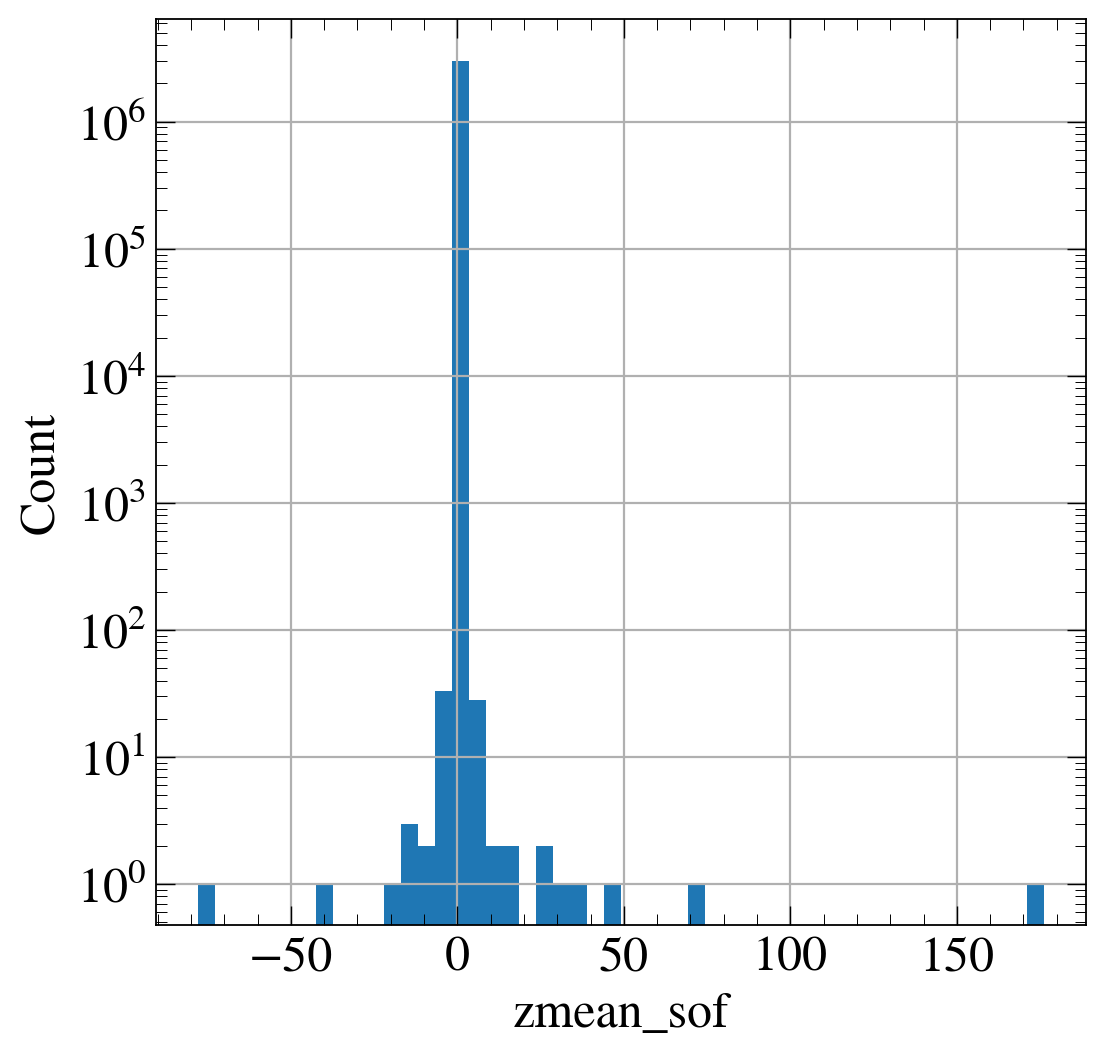

In [20]:
plt.hist(halos['zmean_sof'], bins=50)
plt.yscale('log')
plt.xlabel('zmean_sof')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

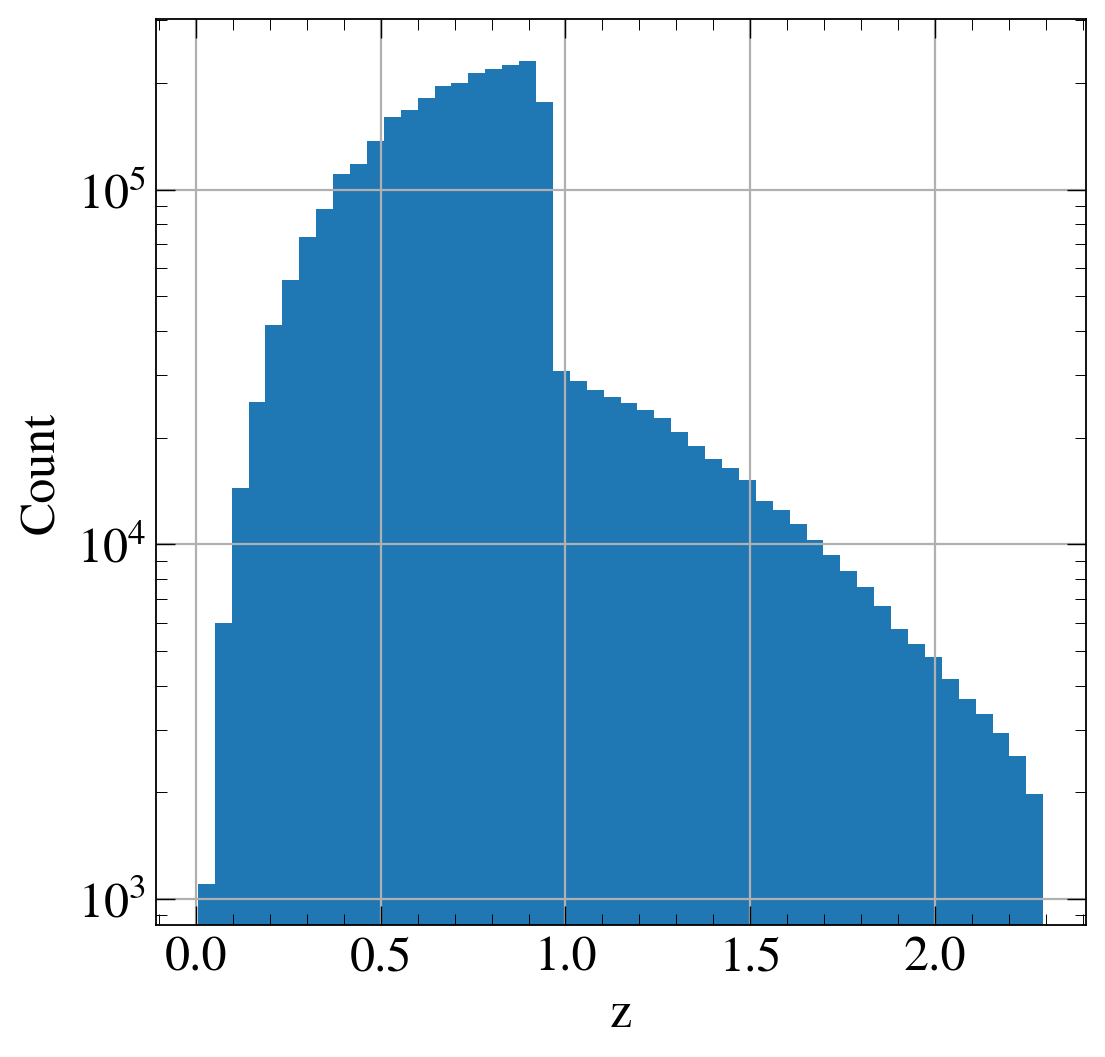

In [21]:
plt.hist(halos['z'], bins=50)
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('Count')

In [33]:
## Matching gold_halos with the corrected file halos
halos_mathched = join(halos, halos_ds, keys=['haloid','Mvir'], join_type='inner')
halos_mathched['Sigma'] = halos_mathched['Sigma']
halos_mathched['DeltaSigma'] = halos_mathched['DeltaSigma']
print(len(halos_mathched))
halos_mathched[:2]

648278


haloid,ra,dec,Mvir,cos_z,coadd_object_id,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int64,float32,float32,float32,float64,int64,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
2545389,307.15073,-42.051777,68890000000000.0,0.2705972848397562,86000938027,167.824,43.7684,0.270594,1.028330532212885,0.37468,-1,0.223423,91154710000000.0,1.11086,2219173286702298.8 .. 1519260804499.2036,66125049107941.375 .. 1333162129154.2285,266948958703480.78 .. 8696439205266.345,-1.6947071735657594e-05 .. -0.15449516342864847,8.507543100463374e-07 .. 0.1256837318098965,12.986549220237457 .. 1.0,92.49977613836931 .. 0.0
2545393,307.27472,-42.053135,88940000000000.0,0.27077192386446014,86000938026,167.698,43.7817,0.270768,1.119819607843137,0.557151,-1,0.55728,105052300000000.0,1.16474,1642214180825270.8 .. 920412980488.0205,-71351623228510.48 .. 1331737286478.438,314150199715222.75 .. 8771544294349.281,4.107503722265713e-05 .. -0.15038856981326063,8.445266097294731e-07 .. 0.13029387077926324,16.192927829939194 .. 1.0,107.76698770385947 .. 0.0


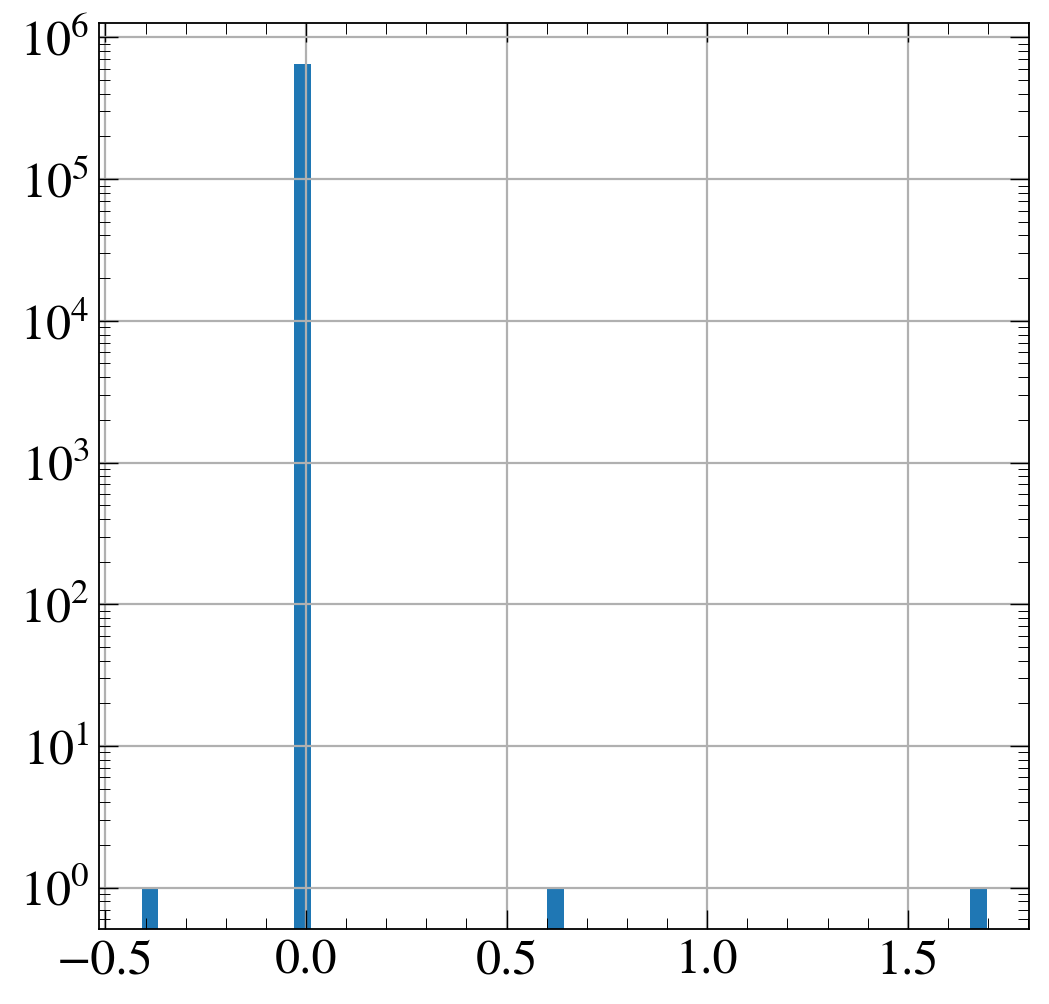

In [30]:
plt.hist(halos_mathched['redshift_cos']-halos_mathched['Redshift'], bins=50)
plt.yscale('log')
plt.show()

# Check halos than ChunHao did not compute their DS and S

In [27]:
all_halos = Table(np.load(file_path+"halos_Mvirgreatthan0_3025241.npy"))
all_halos = all_halos[(all_halos['cos_z']>=0.18) & (all_halos['cos_z']<=0.66) & (all_halos['Mvir']>=1e13)]
print(len(all_halos))
all_halos[:3]

669820


haloid,ra,dec,Mvir,cos_z,coadd_object_id
int64,float32,float32,float32,float64,int64
24147650,45.071865,0.06542971,14130000000000.0,0.48054717318294493,364002802488
34063182,45.117283,0.19532484,21440000000000.0,0.6540988743483402,364004947299
24137076,45.09305,0.21035302,51650000000000.0,0.42517988080369595,364001873725


In [28]:
No_DS_S = all_halos[~np.isin(all_halos['coadd_object_id'], halos_mathched['coadd_object_id'])]
print(len(No_DS_S))
No_DS_S[:3]

21588


haloid,ra,dec,Mvir,cos_z,coadd_object_id
int64,float32,float32,float32,float64,int64
13885120,44.888367,0.62595826,11090000000000.0,0.3166476328853016,364001003533
13883246,44.78746,0.66926765,61420000000000.0,0.31586235907005533,364001002876
13884139,45.098263,1.275296,24750000000000.0,0.3167454360226467,364001003063


In [29]:
halos_mathched['Redshift'].min(), halos_mathched['Redshift'].max(),halos_mathched['Redshift'].min(), halos_mathched['Redshift'].max()

(0.180005, 0.659999, 0.180005, 0.659999)

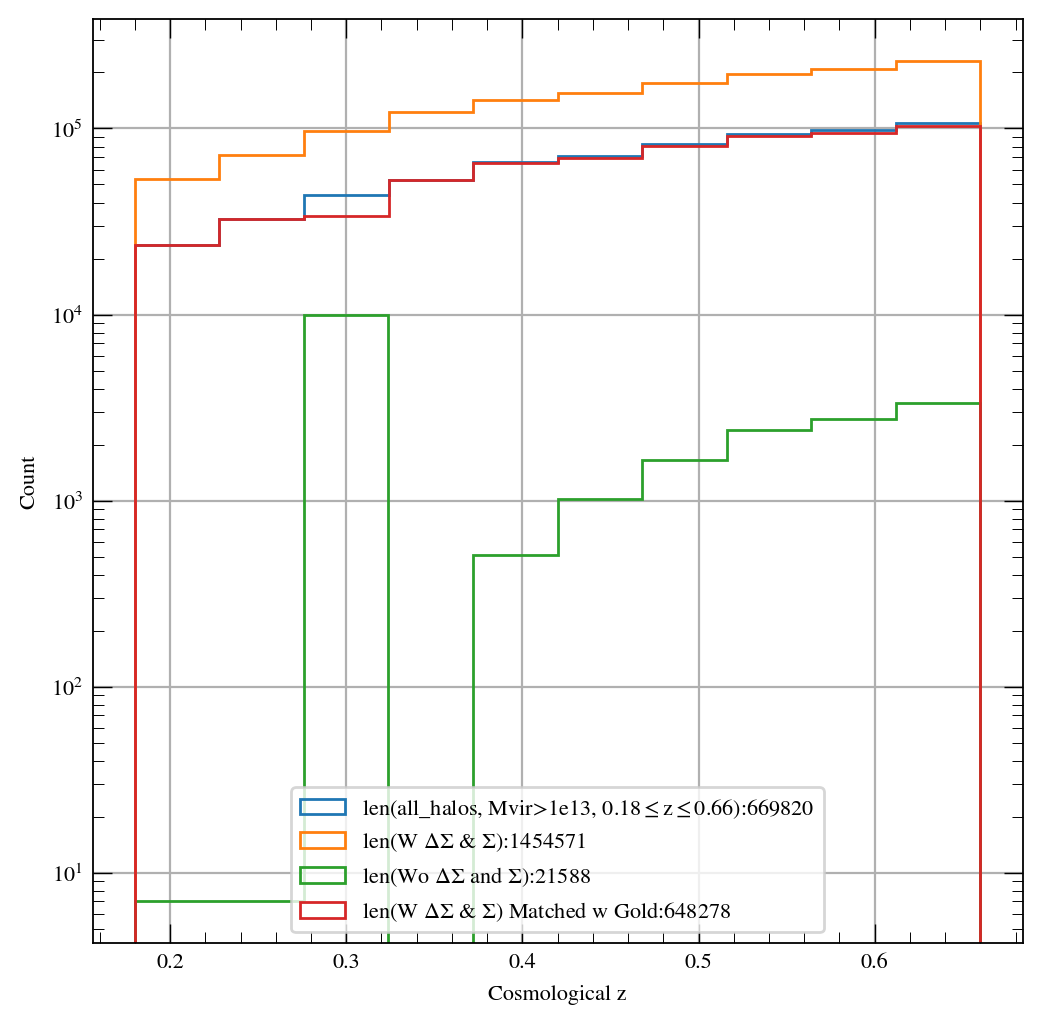

In [33]:
z_range = len(No_DS_S[(No_DS_S['cos_z']>=0.2) & (No_DS_S['cos_z']<1)])
plt.hist(all_halos['cos_z'], alpha=1,label=f'len(all_halos, Mvir>1e13, 0.18$\leq$z$\leq$0.66):{len(all_halos)}', histtype='step')
plt.hist(halos_ds['Redshift'], alpha=1,label=f'len(W $\Delta\Sigma$ & $\Sigma$):{len(halos_ds)}', histtype='step')
plt.hist(No_DS_S['cos_z'], alpha=1,label=f'len(Wo $\Delta\Sigma$ and $\Sigma$):{len(No_DS_S)}', histtype='step')
plt.hist(halos_mathched['Redshift'], alpha=1, label=f'len(W $\Delta\Sigma$ & $\Sigma$) Matched w Gold:{len(halos_mathched)}', histtype='step')
plt.xlabel('Cosmological z')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()
plt.show()

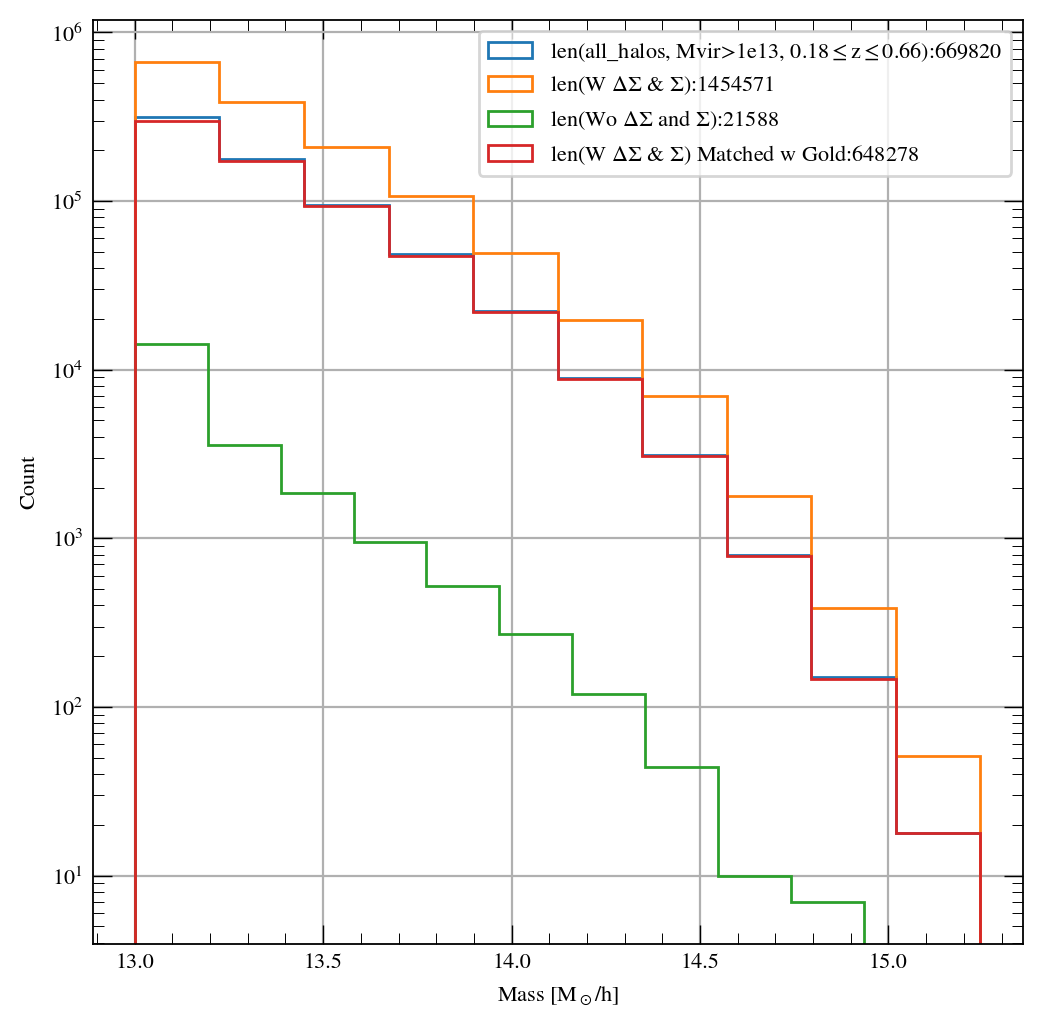

In [35]:
z_range = len(No_DS_S[(No_DS_S['cos_z']>=0.2) & (No_DS_S['cos_z']<1)])
plt.hist(np.log10(all_halos['Mvir']), alpha=1,label=f'len(all_halos, Mvir>1e13, 0.18$\leq$z$\leq$0.66):{len(all_halos)}', histtype='step')
plt.hist(np.log10(halos_ds['Mvir']), alpha=1,label=f'len(W $\Delta\Sigma$ & $\Sigma$):{len(halos_ds)}', histtype='step')
plt.hist(np.log10(No_DS_S['Mvir']), alpha=1,label=f'len(Wo $\Delta\Sigma$ and $\Sigma$):{len(No_DS_S)}', histtype='step')
plt.hist(np.log10(halos_mathched['Mvir']), alpha=1, label=f'len(W $\Delta\Sigma$ & $\Sigma$) Matched w Gold:{len(halos_mathched)}', histtype='step')
plt.xlabel('Mass [M$_\odot$/h]')
plt.ylabel('Count')
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

# Ploting the area of the sky of the Clusters in 100 Patches (Aitoff Projection)

In [52]:
import treecorr

sep_units = 'deg'
plt.rcParams['figure.figsize'] = (9, 9)
halos_mathched['ra'] = halos_mathched['ra'] - 360 * (halos_mathched['ra'] > 180)  # Conversion to avoid overlap
cat_cl = treecorr.Catalog(ra=halos_mathched['ra'], dec=halos_mathched['dec'], ra_units=sep_units, dec_units=sep_units)
ra_cl = cat_cl.ra * (np.pi / 180.0 )  # Convert degrees to radians
dec_cl = cat_cl.dec * (np.pi / 180.0 )  # Convert degrees to radians

In [33]:
import matplotlib.cm as cm
npatch = 100
colors = cm.rainbow(np.linspace(0, 1, npatch))
np.random.shuffle(colors)

In [34]:
ra_rad = halos_mathched['ra'] * (coord.degrees / coord.radians)  # Convert to radians
dec_rad = halos_mathched['dec'] * (coord.degrees / coord.radians)
# Most codes don't know anything about Ra, Dec, so convert to x,y,z on unit sphere.
x, y, z = coord.CelestialCoord.radec_to_xyz(ra_rad, dec_rad)
xyz = np.array([x, y, z]).T

In [35]:
# Used scipy version 1.2.1
import scipy
import time
from scipy.cluster.vq import kmeans, vq
t0 = time.time()
xyz = np.array([x, y, z]).T
cen, distortion = kmeans(xyz, npatch)
scipy_labels = vq(xyz, cen)[0]
t1 = time.time()
scipy_time = t1-t0
print('Time = ',t1-t0)

Time =  128.8917019367218


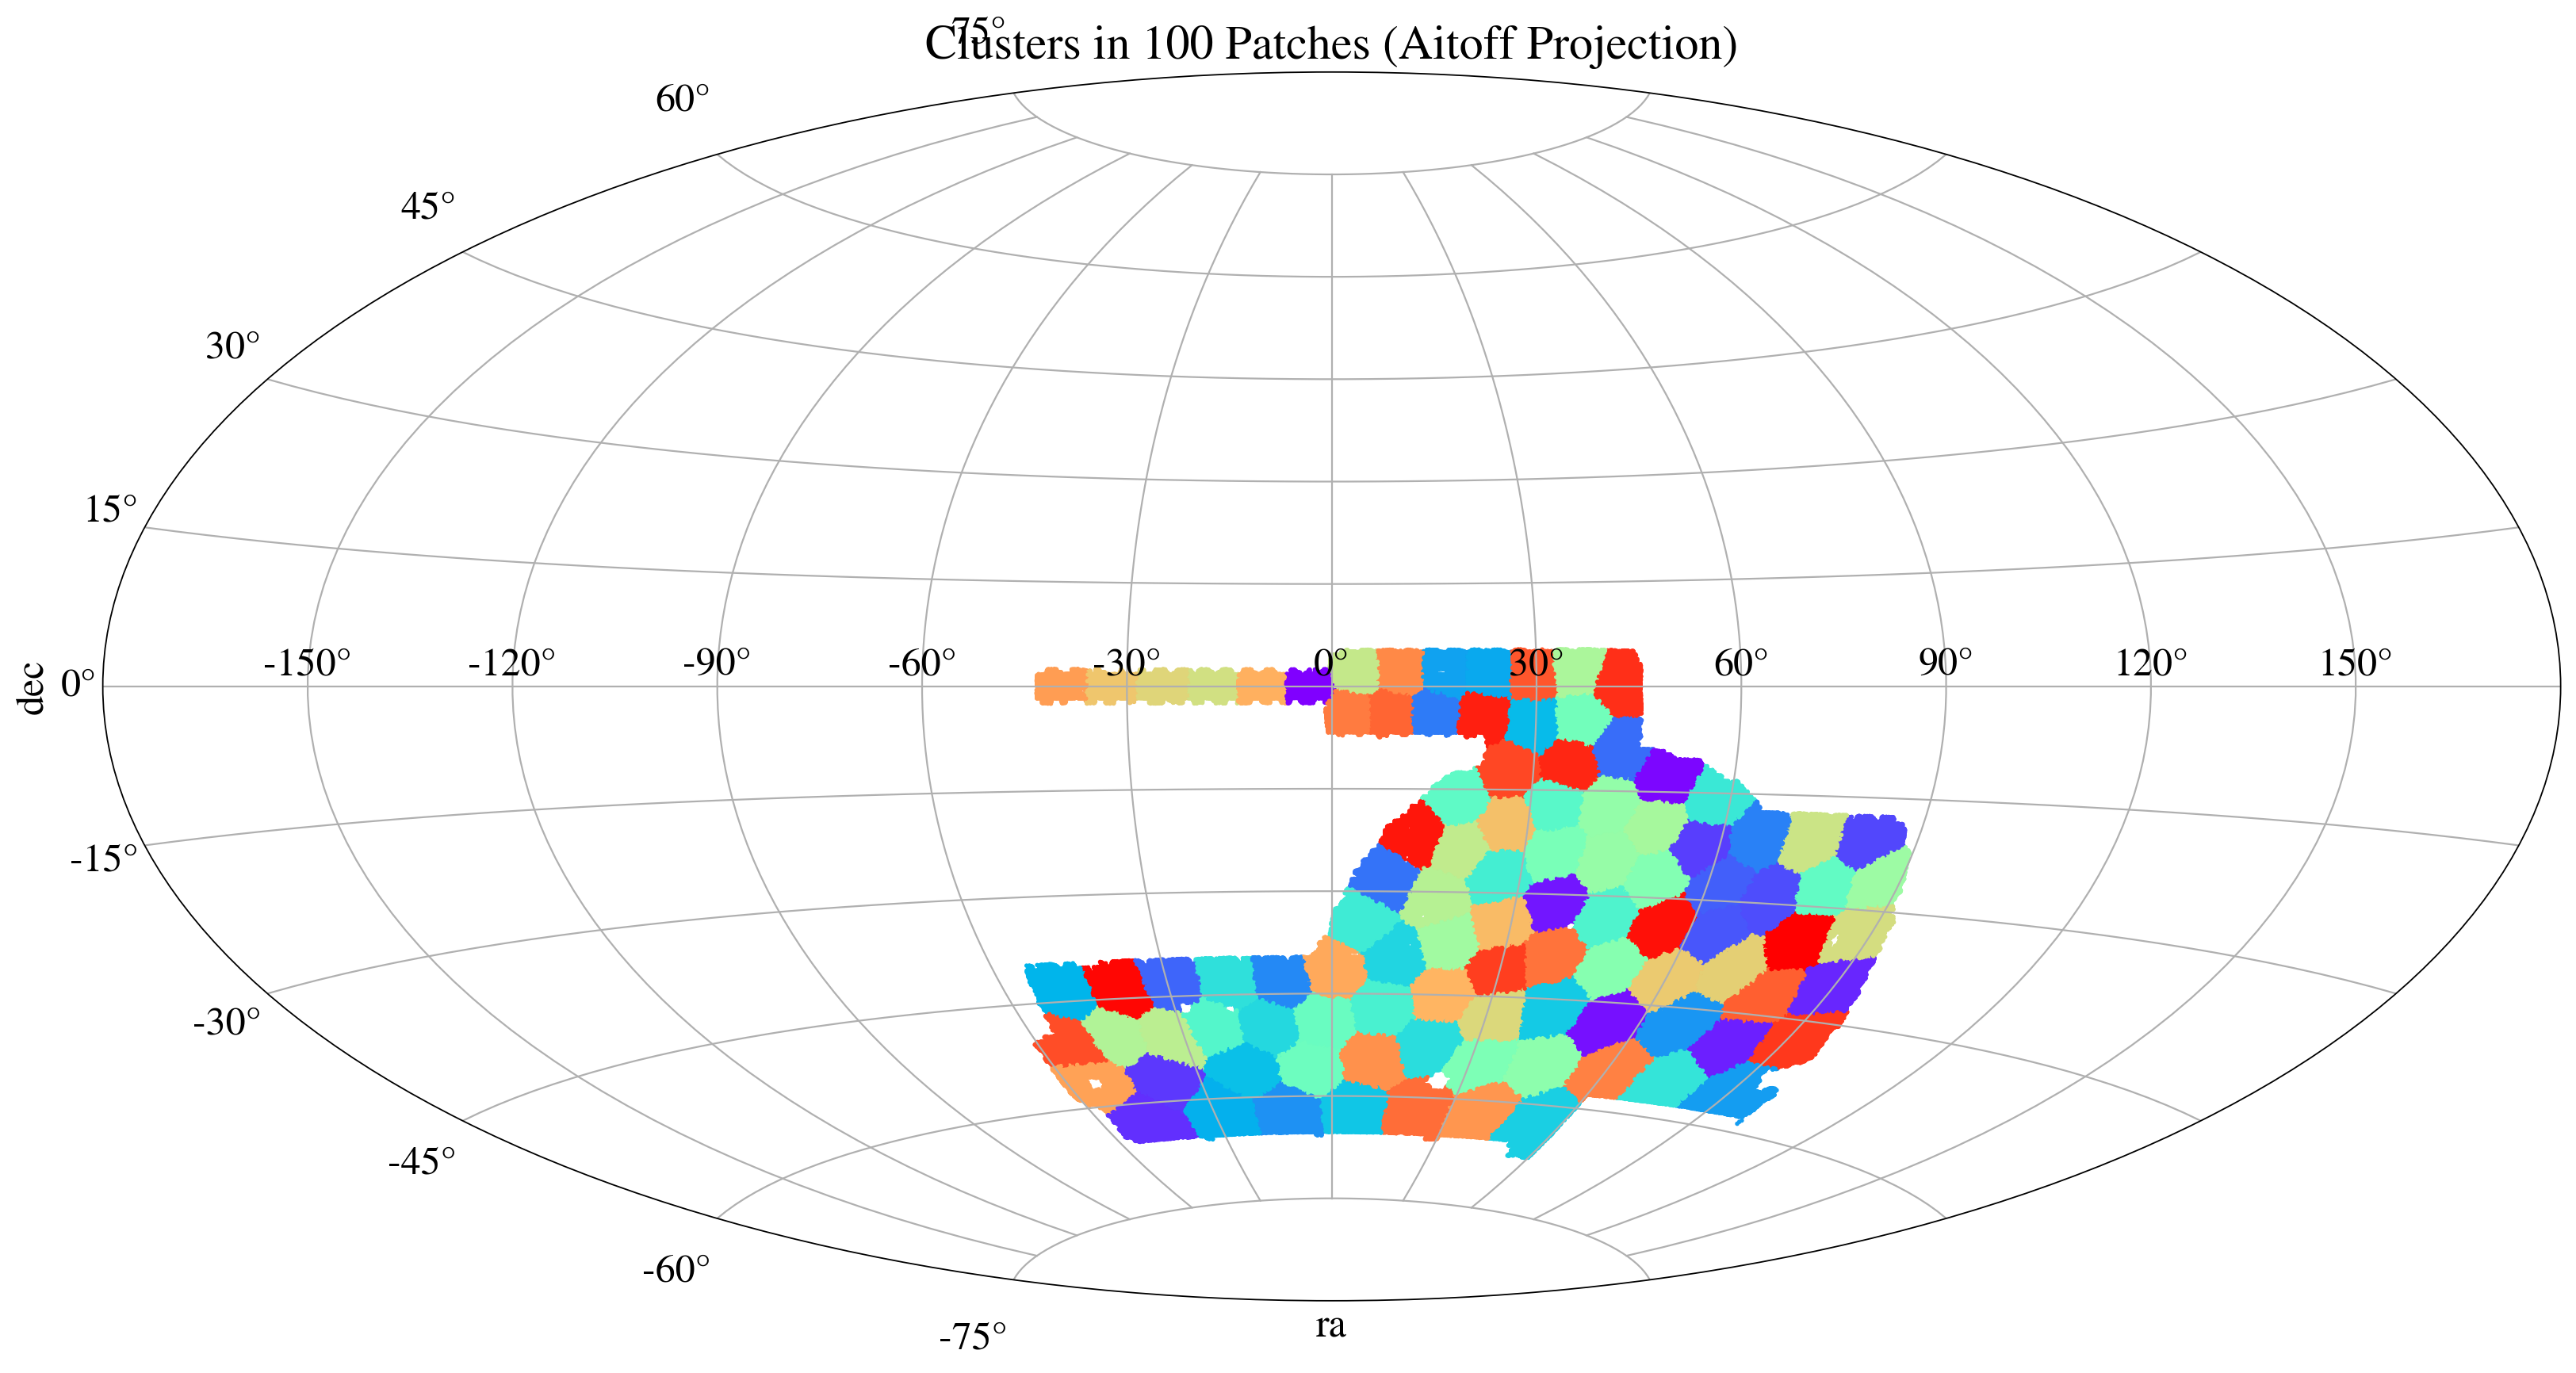

In [36]:
### ra and dec as the coordinate field names
plt.figure(figsize=(20, 15))
plt.subplot(projection="aitoff")
plt.scatter(ra_rad, dec_rad, color=colors[scipy_labels],s=1)

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Clusters in 100 Patches (Aitoff Projection)')
plt.grid(True)
plt.show()

# Computing the error bars by diving the sky into patches

In [7]:
import matplotlib.cm as cm
npatch = 100
colors = cm.rainbow(np.linspace(0, 1, npatch))
np.random.shuffle(colors)

In [8]:
halos_mathched['ra'] = halos_mathched['ra'] - 360 * (halos_mathched['ra'] > 180) 
ra_rad = halos_mathched['ra'] * (np.pi / 180.0 )  # Convert to radians
dec_rad = halos_mathched['dec'] * (np.pi / 180.0 )
# Most codes don't know anything about Ra, Dec, so convert to x,y,z on unit sphere.
sky_coord = SkyCoord(ra=ra_rad, dec=dec_rad, unit='radian')

# Extract x, y, z coordinates from the SkyCoord object
x = sky_coord.cartesian.x.value
y = sky_coord.cartesian.y.value
z = sky_coord.cartesian.z.value
xyz = np.array([x, y, z]).T

In [9]:
# Used scipy version 1.2.1
import scipy
import time
from scipy.cluster.vq import kmeans, vq
t0 = time.time()
xyz = np.array([x, y, z]).T
cen, distortion = kmeans(xyz, npatch)
scipy_labels = vq(xyz, cen)[0]
t1 = time.time()
scipy_time = t1-t0
print('Time = ',t1-t0)

Time =  163.629296541214


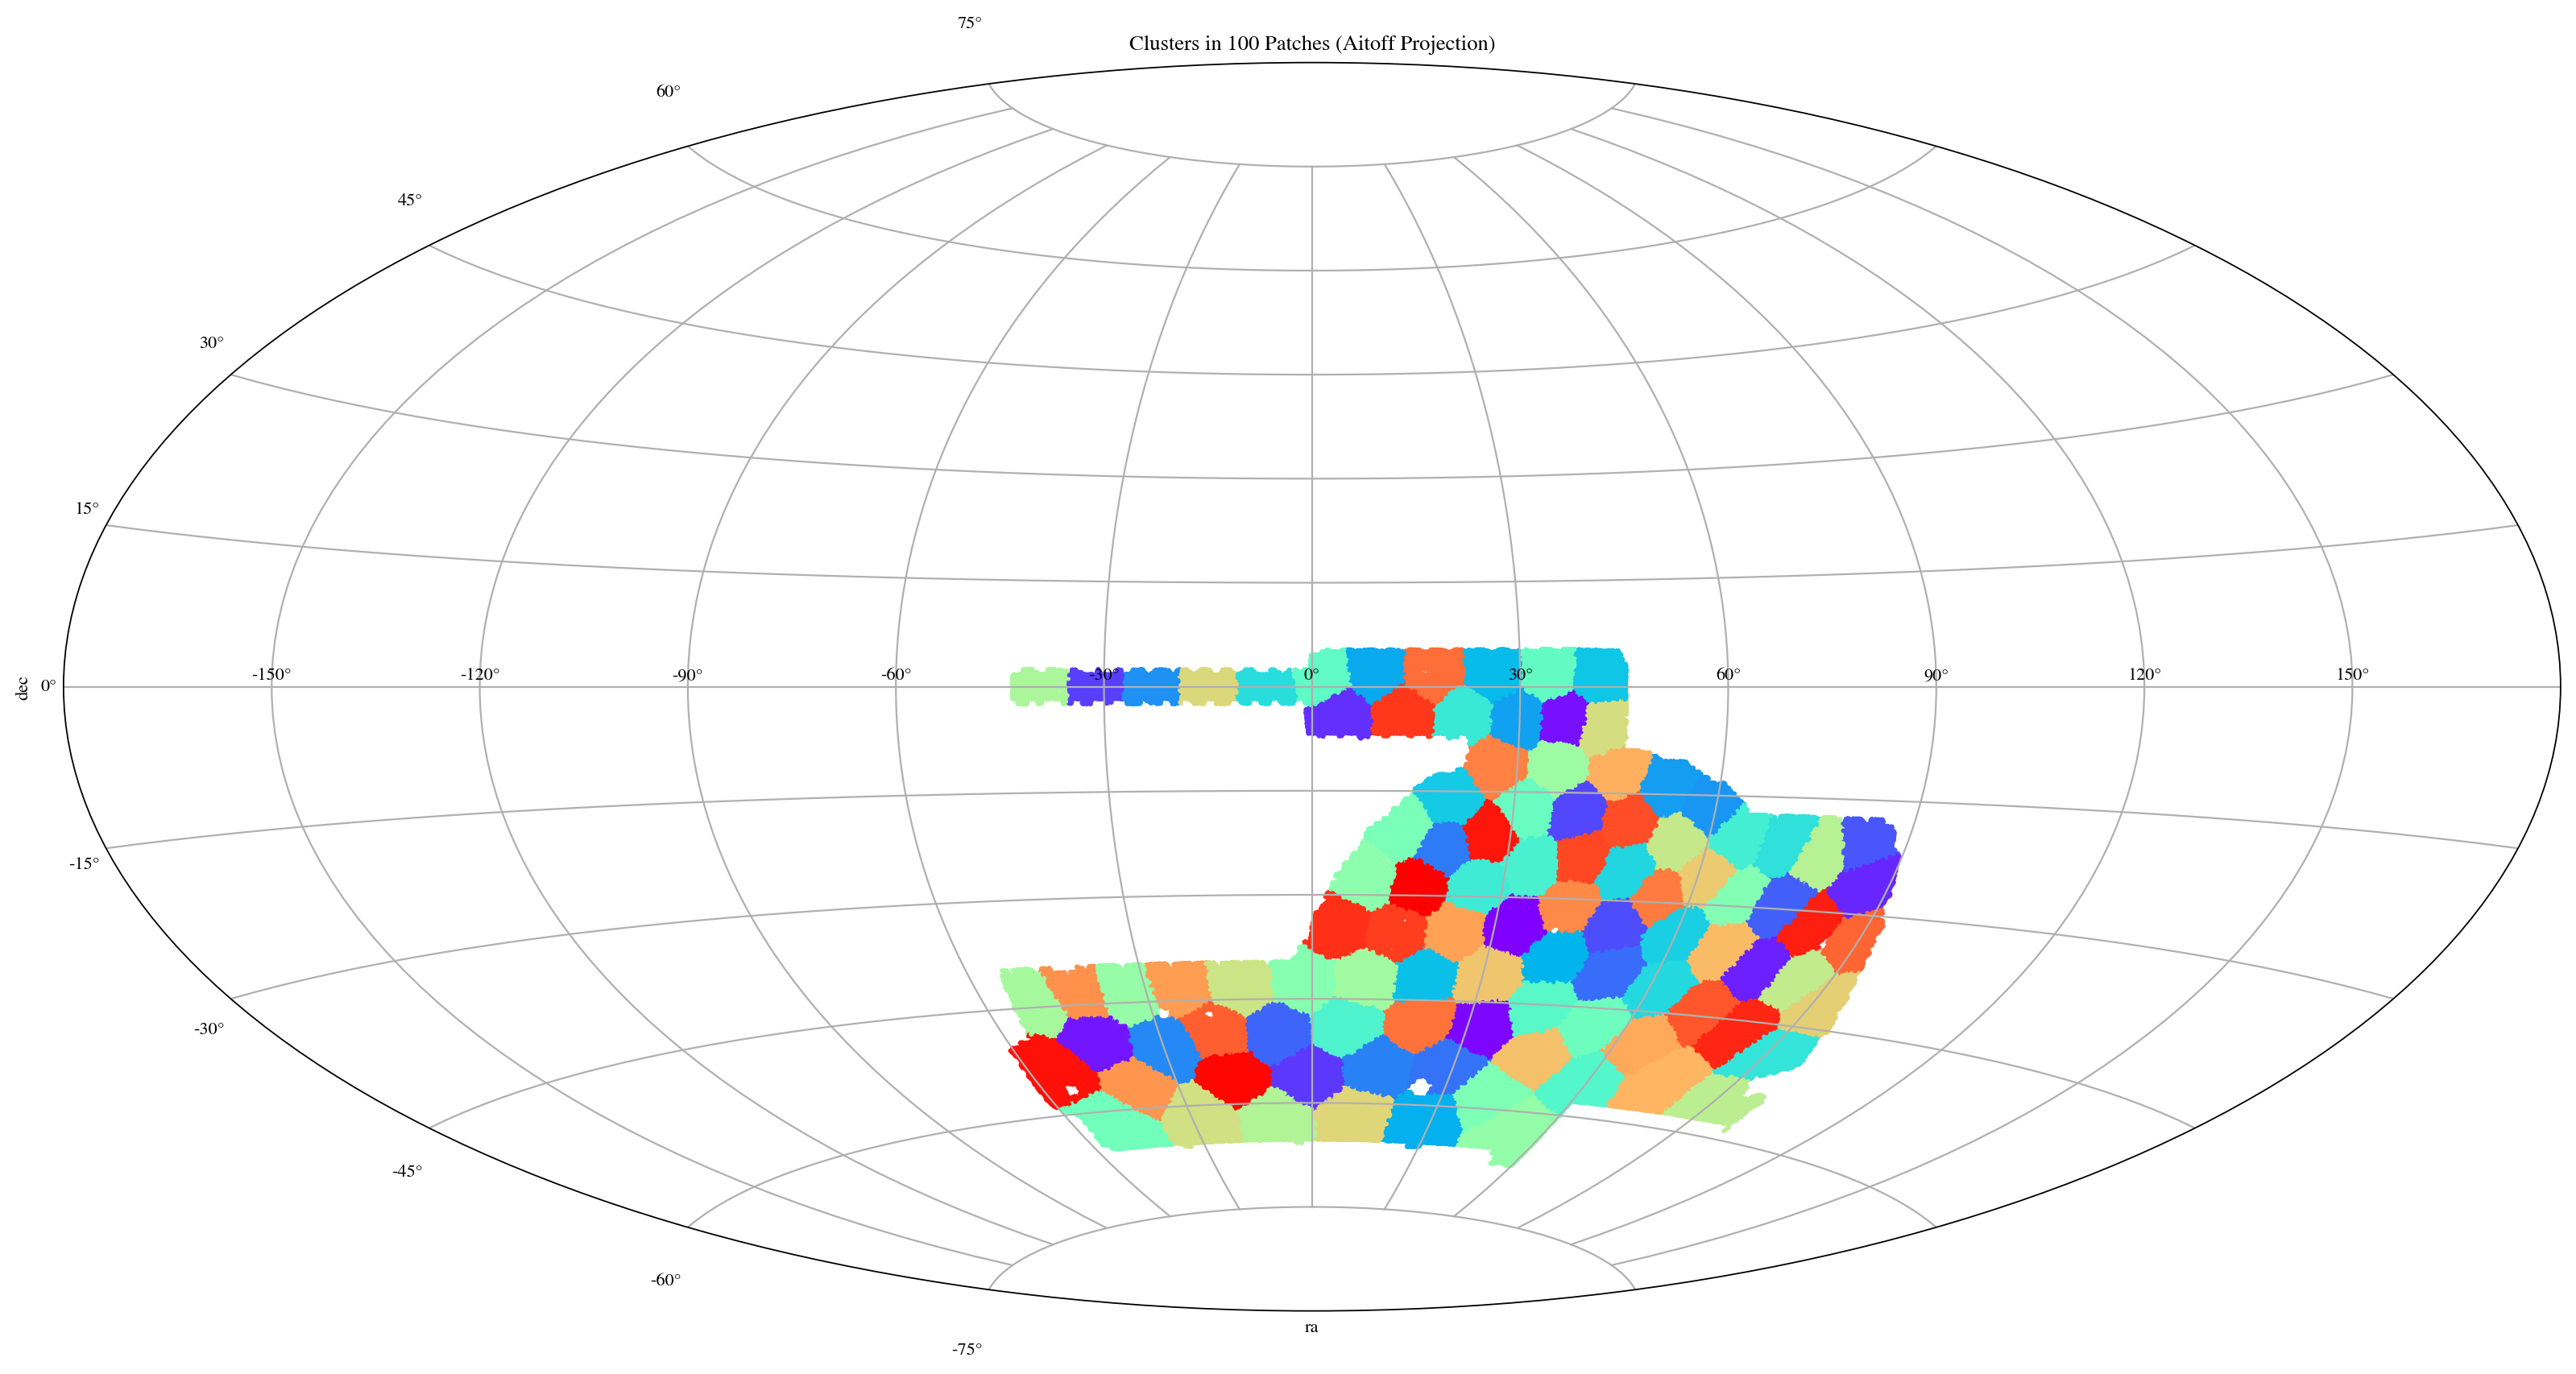

In [10]:
### ra and dec as the coordinate field names
plt.figure(figsize=(20, 15))
plt.subplot(projection="aitoff")
plt.scatter(ra_rad, dec_rad, color=colors[scipy_labels],s=1)

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Clusters in 100 Patches (Aitoff Projection)')
plt.grid(True)
plt.show()

In [35]:
halos_mathched['patch_label'] = scipy_labels

In [36]:
jackknife_samples_append = []
jackknife_samples_extend = []
# Perform jackknife leave-out approach
for cluster_label in np.unique(scipy_labels):
    # Leave out data points belonging to the current cluster label
    jackknife_sample = halos_mathched[halos_mathched['patch_label'] != cluster_label]['DeltaSigma']
    jackknife_samples_extend.extend(jackknife_sample)
    jackknife_samples_append.append(jackknife_sample.data)

In [37]:
print([len(i) for i in jackknife_samples_append])

[643182, 640016, 641966, 640907, 642303, 641940, 641039, 643102, 641765, 641280, 641520, 641637, 641389, 641336, 641748, 642597, 642113, 641891, 642051, 640795, 640721, 640164, 642061, 642084, 641224, 641308, 642251, 642626, 641246, 643120, 641743, 641288, 640481, 642100, 642522, 640861, 641342, 641121, 641038, 642606, 641418, 643793, 641544, 642523, 642552, 643708, 641116, 641137, 641683, 641491, 640865, 643786, 642074, 642292, 640727, 641552, 641912, 642082, 644270, 641697, 641151, 641940, 642833, 643113, 641093, 641888, 640806, 641352, 640999, 640701, 642328, 642406, 640626, 642827, 641443, 640636, 641320, 642724, 640736, 640665, 641649, 642674, 640915, 642141, 641606, 640791, 641349, 642161, 641181, 640765, 641262, 641597, 644405, 641516, 643150, 642642, 642049, 642200, 642168, 643008]


In [38]:
jackknife_samples_append[0]

array([[ 6.61250491e+13,  7.47108289e+13,  6.81101036e+13, ...,
         3.36653299e+12,  1.62822683e+12,  1.33316213e+12],
       [-7.13516232e+13,  4.33546173e+13,  5.46292031e+13, ...,
         2.79564355e+12,  1.54143375e+12,  1.33173729e+12],
       [ 4.21629422e+13,  6.94348192e+13,  8.24858225e+13, ...,
         1.00577482e+12,  5.26110390e+11,  5.27427542e+11],
       ...,
       [-9.73609519e+13, -2.47424108e+13,  2.99643212e+12, ...,
         4.03498092e+10, -1.39417086e+12, -2.15347398e+12],
       [-7.55389094e+13, -4.03389328e+13, -3.76108339e+12, ...,
         8.39807671e+11,  1.50090271e+12,  8.60571867e+11],
       [ 4.43286751e+13,  2.94339066e+13,  2.04497582e+13, ...,
         6.55698362e+11,  1.42594792e+12,  9.74281657e+11]])

In [39]:
stds_jackknife = [np.std(jack_sample, axis=0)for jack_sample in jackknife_samples_append]
print(len(stds_jackknife))

100


In [40]:
mean_std_dev = np.mean(stds_jackknife, axis=0)
mean_std_dev

array([6.84259582e+13, 4.72985401e+13, 3.63181985e+13, 2.82386129e+13,
       2.11515574e+13, 1.54541133e+13, 1.11250999e+13, 7.89639052e+12,
       5.41766877e+12, 3.63372948e+12, 2.53227607e+12, 1.88450206e+12,
       1.47819973e+12, 1.20778752e+12, 9.98546274e+11])

In [45]:
halos_mathched['DeltaSigma'].mean(axis=0)-mean_std_dev

array([-5.57468918e+13, -2.12934484e+13, -9.85553432e+11,  8.88142670e+12,
        1.04465650e+13,  7.69482379e+12,  4.10882781e+12,  1.23810782e+12,
       -3.74818931e+11, -9.31692391e+11, -9.88920071e+11, -9.02539361e+11,
       -7.94634809e+11, -7.05984965e+11, -6.28885491e+11])

[]

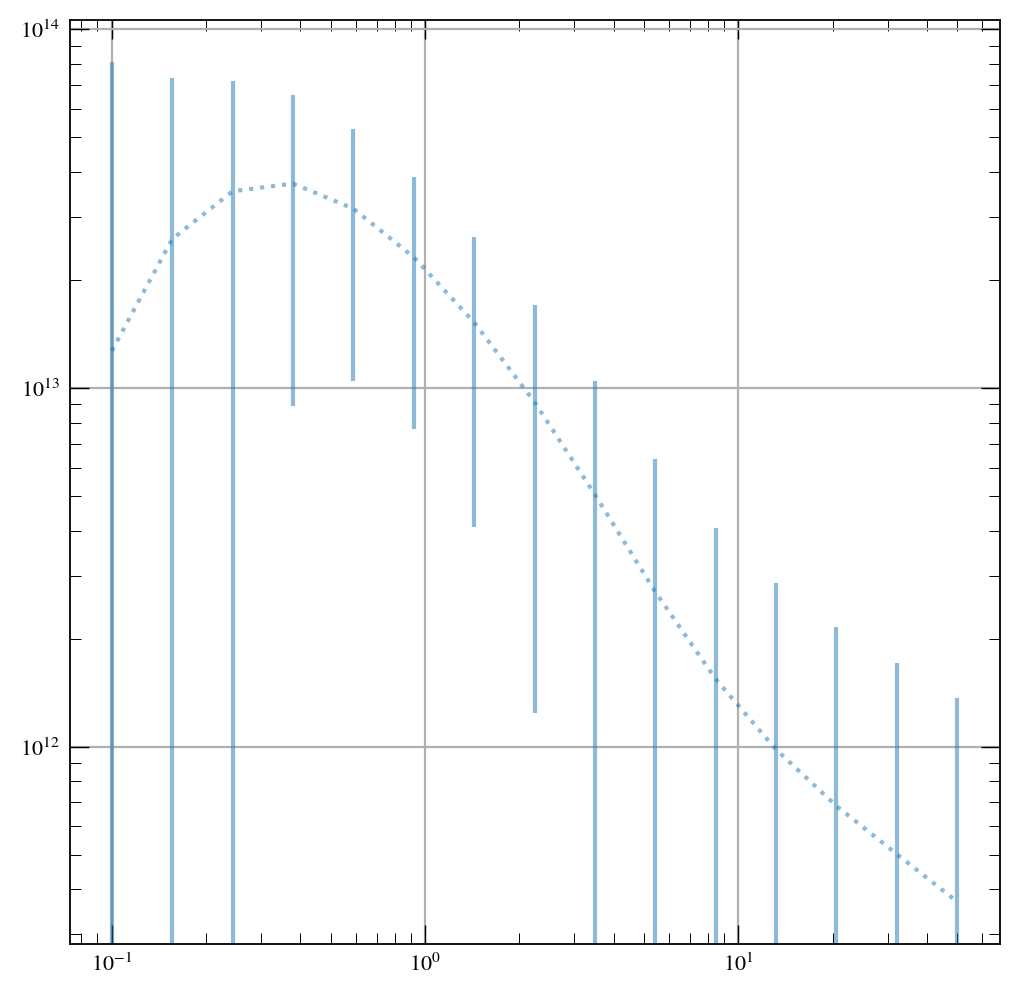

In [47]:
# plt.loglog(bins,halos_ds['DeltaSigma'].mean(axis=0))
# plt.errorbar(bins,halos_mathched['DeltaSigma'].mean(axis=0),yerr=halos_mathched['DeltaSigma'].std(axis=0),alpha=0.5)
# plt.errorbar(bins,halos_mathched['DeltaSigma'].mean(axis=0),yerr=std_jackknife,alpha=0.5, linestyle=':')
plt.errorbar(bins,halos_mathched['DeltaSigma'].mean(axis=0),yerr=mean_std_dev,alpha=0.5, linestyle=':')
plt.loglog()

[]

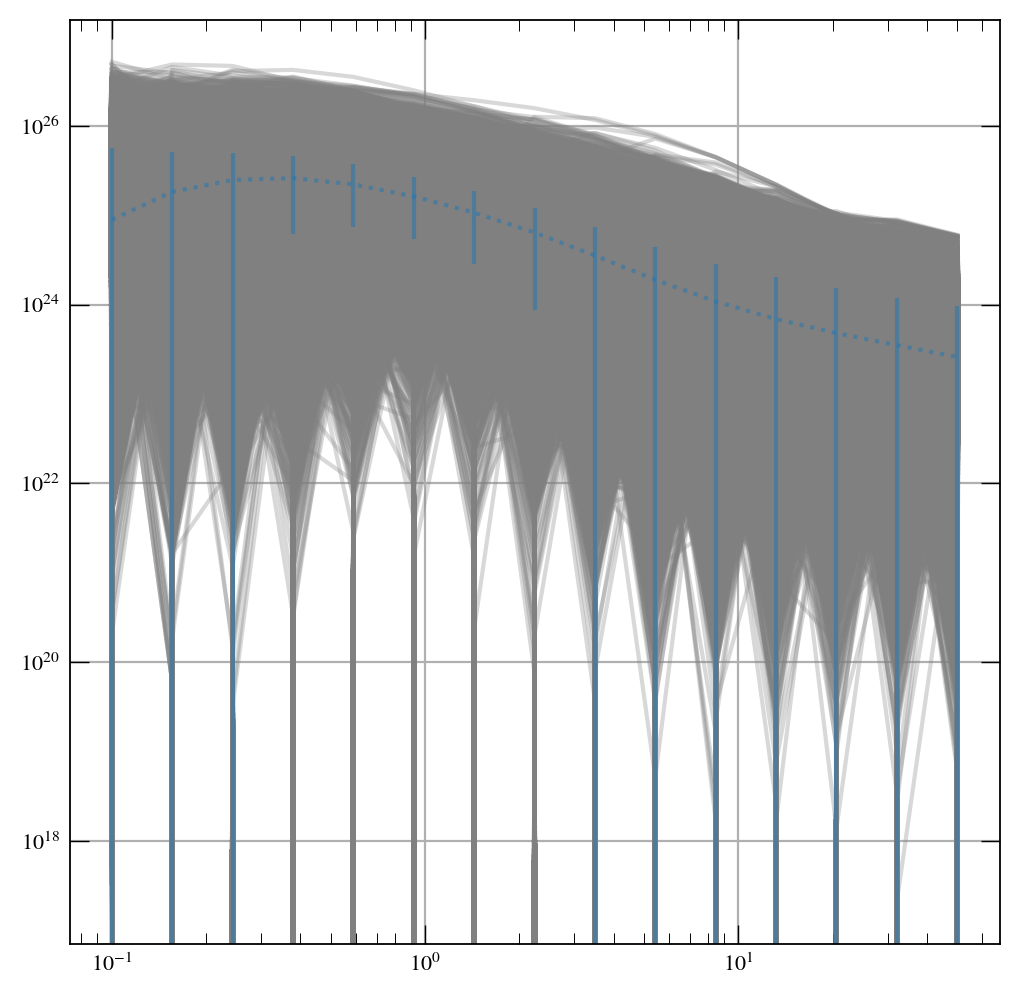

In [31]:
for i in range(len(halos_mathched['DeltaSigma'])):
    plt.loglog(bins,halos_mathched['DeltaSigma'][i],c='gray', alpha=0.3)
    
    
plt.errorbar(bins,halos_mathched['DeltaSigma'].mean(axis=0),yerr=std_jackknife, color='red')
plt.loglog()

# Paper Figure 1

In [5]:
h=0.7

In [6]:
halo_mass_bin = halos_ds[(halos_ds['Mvir']>=1e14) &
                                 # (sigma_ds_profile['halo_mass']<=2e14) & 
                                (halos_ds['Redshift']>=0.2) & 
                                     (halos_ds['Redshift']<0.25)]

halo_mass_bin[:2]

haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12502745,1258000000000000.0,28.5188,42.6599,0.245169,2.7565576592082612,0.121162,-1,0.481589,1318194000000000.0,2.70641,4791001817362133.0 .. 10223793787277.748,13929368888834.93 .. 2443808275746.888,849868716235182.9 .. 11582368499316.416,1.8922688311591405e-05 .. 2.635382399211429,1.252259828690655e-07 .. 0.23686058995200038,544.8960005870362 .. 1.0,221.6253743309008 .. 0.0
5243055,1005000000000000.0,164.928,39.2735,0.241033,2.5550889271371195,0.674953,-1,0.556159,1178582000000000.0,2.60725,4772530453760931.0 .. 9729975312871.023,91152279582919.64 .. 1950215521267.1614,872925512776259.9 .. 11204418166977.473,5.581314812471245e-06 .. 0.031271592707993255,4.091531133879263e-07 .. 0.1710336382885212,582.4859068617167 .. 1.0,220.73764316578496 .. 0.0


In [7]:
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70, 'Om0':0.286, 'Ob0': 0.047,'sigma8': 0.82, 'ns':0.96} # - gcosmology.Ob0
cosmo = cosmology.setCosmology('cosmo', params)

# vol_hiMpc3 = (5000/(4*np.pi*((180/np.pi)**2)))*(4*np.pi/3)*(self.cosmo.comovingDistance(z_max=self.redshift_max)**3 - self.cosmo.comovingDistance(z_max=self.redshift_min)**3)

In [8]:
# profile_dk14.DK14Profile

/bsuhome/gladyskamau/mambaforge/envs/bsu/lib/python3.11/site-packages/colossus/halo/profile_base.py:962: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  surfaceDensity[i], _ = scipy.integrate.quad(integrand, log_r_use[i], log_max_r,


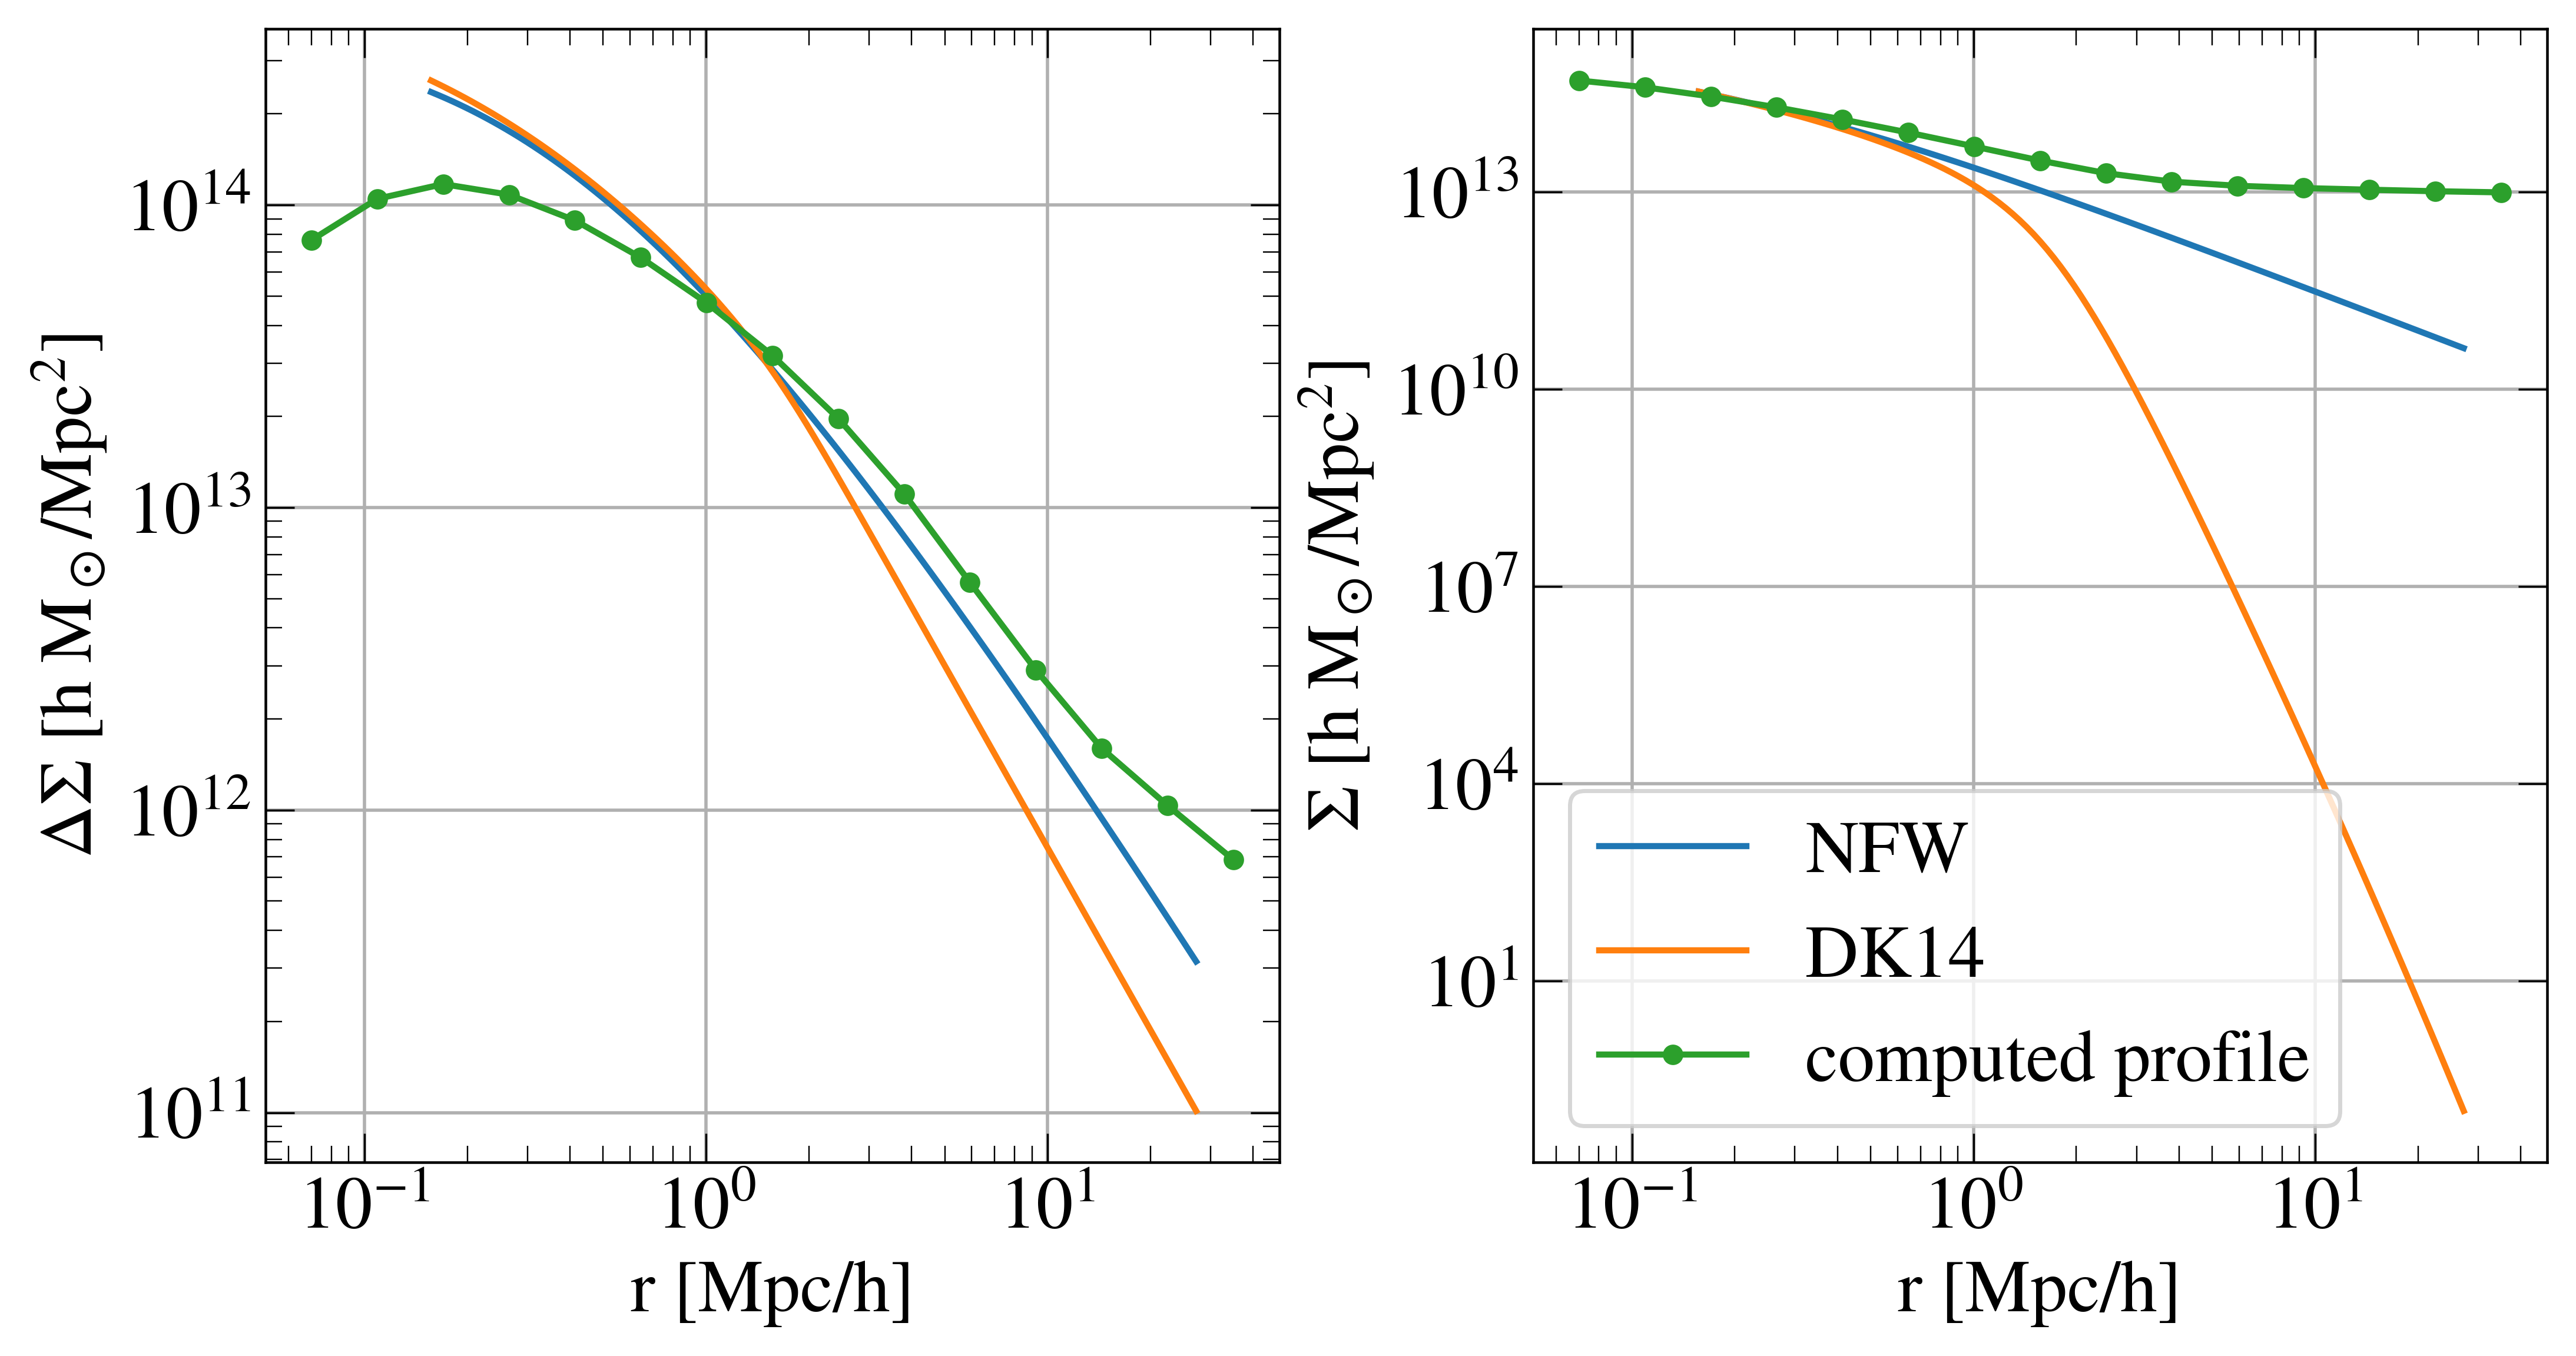

In [9]:
from colossus.halo import profile_nfw, profile_dk14, concentration

Mvir = halo_mass_bin['Mvir'].mean() # has h 
z = halo_mass_bin['Redshift'].mean()
cvir = concentration.concentration(M=Mvir, mdef='vir', z=z, )

p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_dk14 = profile_dk14.DK14Profile(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_term_names = ['pl']) 

r = (10**np.arange(2.35,4.6,0.02))*h # np.logspace(-2, 1.4, 20) # 
rho_nfw_ds = p_nfw.deltaSigma(r)
rho_dk14_ds = p_dk14.deltaSigma(r)

rho_nfw_s = p_nfw.surfaceDensity(r)
rho_dk14_s = p_dk14.surfaceDensity(r)

# Create four subplots
fig, axs = plt.subplots(1, 2,figsize=(10, 5), dpi=500)
axs = axs.flatten()

# for i in range(halo_mass_bin.shape[0]):
#     plt.plot(halo_mass_bin['radius'][i],halo_mass_bin['DS'][i],c='grey',alpha=0.1)
    
axs[0].plot(r*1e-3, rho_nfw_ds*1e6, '-', label = 'NFW')
axs[0].plot(r*1e-3, rho_dk14_ds*1e6, '-', label = 'DK14')  
axs[0].plot(bins*h, halo_mass_bin['DeltaSigma'].mean(axis=0), marker = 'o', ms = 4.0, label = 'computed profile')
axs[0].set_xlabel('r [Mpc/h]')
axs[0].set_ylabel('$\Delta\Sigma ~ [\mathrm{h~ M}_\odot /\mathrm{Mpc}^2}$]')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# for i in range(halo_mass_bin.shape[0]):
#     plt.plot(halo_mass_bin['radius'][i],halo_mass_bin['sigma'][i],c='grey',alpha=0.1)
    
axs[1].plot(r*1e-3, rho_nfw_s*1e6, '-', label = 'NFW')
axs[1].plot(r*1e-3, rho_dk14_s*1e6, '-', label = 'DK14')
axs[1].plot(bins*h, halo_mass_bin['Sigma'].mean(axis=0), marker = 'o', ms = 4.0, label = 'computed profile')
# axs[1].plot((halo_mass_bin_new['radius'].mean()), halo_mass_bin_new['sigma'].mean(), marker = 'o', ms = 4.0, label = 'computed DS New')
axs[1].set_xlabel('r [Mpc/h]')
axs[1].set_ylabel('$\Sigma ~[ \mathrm{h~ M}_\odot /\mathrm{Mpc}^2}$]')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

plt.subplots_adjust(wspace=0.25)
plt.legend()
# plt.savefig(filep + 'Images/skysim_DS&S.png', facecolor='white')
plt.show()